In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.colors as colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.collections import LineCollection
from matplotlib import cm
from datetime import datetime
from scipy.special import gamma
from scipy.interpolate import interp1d

In [2]:
# Helper function to - you guessed it - make sexy axes for generic values
def sexy_axes(ax,fs):
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left') 
    ax.tick_params('both',labelsize=fs,rotation=45)

In [3]:
# Helper function to make sexy axes for pressure levels
def sexy_axes2(ax, fs, ylab):
    ax.set_ylim([50,800])
    ax.set_yscale('log')
    ax.set_yticks([800,500,300,100])
    ax.set_yticklabels(['800','500','300','100'])
    if ylab == True:
        ax.set_ylabel('Pressure [hPa]',fontsize=fs)
    ax.invert_yaxis()
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left') 
    ax.tick_params('both',labelsize=fs,rotation=45)

## Figure 1: Domain topography and vertical grid spacing

In [4]:
# Domain topography map
file = '/work/bb1018/b380459/TROPIC/extpar/extpar_icon-grid_tropic_55e170e5s40n_R2500m_bitmap.nc'
dset = xr.open_dataset(str(file))
x, y = dset['lon'].values, dset['lat'].values  # shape = (9648304,)

# Flight 7 track
basedir = '/work/bb1018/b380873/tropic_vis/'
scfi = basedir + 'obs/stratoclim2017.geophysika.0808_1.master.ci_eval.nc'
sc_data = xr.open_dataset(scfi)
lat_sc = sc_data['BEST:LAT'].values
lon_sc = sc_data['BEST:LON'].values
t_sc = sc_data['time'].values
i_sc = np.argwhere((~np.isnan(lat_sc)) & (~np.isnan(lon_sc)) & (lat_sc > 0) & (lon_sc > 0))

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Truncate a coloramp by specifying the start and endpoint."""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n}.{a:.2f},{b:.2f})'.format(n=cmap.name,a=minval,b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return(new_cmap)

In [6]:
# Load the default vertical grid with 75 levels.
basedir = '/work/bb1018/b380873/'
vgrid = xr.open_dataset(basedir + 'vgrid_icon-grid_tropic_55e115e5s40n.nc')
vct_a = vgrid['vct_a'].values
diff1 = np.zeros((vct_a.shape[0]-1,2))
for i in np.arange(vct_a.shape[0]-1):
    d = vct_a[i] - vct_a[i+1]
    diff1[i,0] = d[0]
    d = (vct_a[i] + vct_a[i+1])/2
    diff1[i,1] = d[0]

In [7]:
# Load the higher-resolution vertical grid with 120 levels.
vgrid = xr.open_dataset(basedir + 'vgrid_max_lay_thckn_200.nc')
vct_a = vgrid['vct_a'].values
diff2 = np.zeros((vct_a.shape[0]-1,2))
for i in np.arange(vct_a.shape[0]-1):
    d = vct_a[i] - vct_a[i+1]
    diff2[i,0] = d[0]
    d = (vct_a[i] + vct_a[i+1])/2
    diff2[i,1] = d[0]

In [ ]:
fs = 16
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
cmap = truncate_colormap(plt.get_cmap('terrain'), 0.2, 1.)
ax1.tricontourf(x, y, dset['topography_c'], cmap=cmap, levels=np.arange(-100,8500,10))
print(dset['topography_c'].max())
ax1.coastlines()
ax1.set_extent([55, 115, -5, 40],crs=ccrs.PlateCarree())
ax1.text(0.07,0.92,'(a)',weight='bold',fontsize=fs+4,transform=ax1.transAxes)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fs}
gl.ylabel_style = {'size': fs}

# Pulling from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
# Create a set of line segments so that we can color them individually
points = np.array([lon_sc[i_sc[:,0]],lat_sc[i_sc[:,0]]]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]],axis=1)

# Convert the times from np.datetime64 to float
t_sc1 = t_sc[i_sc[:,0]]
t_sc_f = t_sc1.astype("float")/1000000000.0
t_sc_f = t_sc_f - np.nanmin(t_sc_f)
norm = plt.Normalize(t_sc_f.min(),t_sc_f.max())
lc = LineCollection(segments,cmap=cm.autumn,norm=norm)
lc.set_array(t_sc_f)
lc.set_linewidth(2)
ax1.add_collection(lc)

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(diff1[:,0],diff1[:,1]/1000,color='red')
ax2.plot(diff2[:,0],diff2[:,1]/1000,color='blue')
ax2.set_xlabel('Layer thickness [m]',fontsize=fs)
ax2.set_ylabel('Altitude [km]',fontsize=fs)
ax2.set_ylim([0,30])
ax2.set_xlim([0,1300])
ax2.text(0.6,0.17,'default vgrid',color='red',fontsize=fs+2,transform=ax2.transAxes)
ax2.text(0.6,0.07,'hi-res vgrid',color='blue',fontsize=fs+2,transform=ax2.transAxes)
ax2.text(0.07,0.92,'(b)',weight='bold',fontsize=fs+4,transform=ax2.transAxes)
sexy_axes(ax2,fs)
fig.savefig('./output/1-topography-vgrid-spacing.png',bbox_inches='tight')

<xarray.DataArray 'topography_c' ()>
array(8444.875)


## Figure 2: OLR maps and bin-smoothed histograms

In [189]:
# Read in the CERES data.
basedir = '/work/bb1018/b380873/tropic_vis/obs/CERES/'
olr_data = xr.open_dataset(basedir + 'CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Subset_20170801-20170831_full-domain.nc')
olr_ceres = olr_data.toa_lw_all_1h.sel(time=slice(datetime(2017,8,7,12,0,0),datetime(2017,8,8,12,0,0)))
olr_ceres = olr_ceres.mean(dim={'time'})
lons_ceres = olr_data.lon
lats_ceres = olr_data.lat

In [190]:
# Read in the ERA5 values.
basedir = '/work/bb1018/b380873/tropic_vis/obs/ERA5/'
olr_data = xr.open_dataset(basedir + 'ERA5_OLR-20170805-20170809.nc')
olr_era5 = olr_data.ttr.sel(time=slice(datetime(2017,8,7,12,0,0),datetime(2017,8,8,12,0,0)))
olr_era5 = -1.*olr_era5.mean(dim={'time'})/3600
lons_era5 = olr_data.longitude
lats_era5 = olr_data.latitude

In [191]:
# Read in the ICON 1-mom simulation.
basedir = '/work/bb1018/b380873/ICON_output/'
olr_data = xr.open_dataset(basedir + 'OLR_24h_tropic_run2_ll.nc')
olr_icon_1mom = -1.*olr_data.lwflxall.mean(dim={'time'}).sel(height=1)
lons_icon = olr_data.lon
lats_icon = olr_data.lat

# Read in the ICON 2-mom simulation.
olr_data = xr.open_dataset(basedir + 'OLR_24h_tropic_run5_ll.nc')
olr_icon_2mom = -1.*olr_data.lwflxall.mean(dim={'time'}).sel(height=1)

# Read in the ICON rad2mom simulation.
olr_data = xr.open_dataset(basedir + 'OLR_24h_tropic_run7_rad2mom_ll.nc')
olr_icon_rad2mom = -1.*olr_data.lwflxall.mean(dim={'time'}).sel(height=1)

# Read in the ICON PDA simulation.
olr_data = xr.open_dataset(basedir + 'OLR_24h_tropic_run8_pda_ll.nc')
olr_icon_pda = -1.*olr_data.lwflxall.mean(dim={'time'}).sel(height=1)

In [228]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [201]:
# pulling this from the following stackoverflow
# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
def resize_colorbar(event):
    plt.draw()
    posn = ax.get_position()
    # left, bottom, width, height
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0 - 0.015,
                          0.025, posn.height + 0.03])
    cbar_ax.tick_params(labelsize=fs)
    #cbar_ax.set_ylabel(r'W m$^{-2}$', size=fs)

In [243]:
levs = np.linspace(80,375,15)
titre = [r'$\bf{' + '(a)' + '}$' + ' CERES',r'$\bf{' + '(b)' + '}$' + ' ERA5',
         r'$\bf{' + '(c)' + '}$' + ' 1M_0V_0A_0C',r'$\bf{' + '(e)' + '}$' + ' 2M_1V_0A_0C',
         r'$\bf{' + '(f)' + '}$' + ' 2M_1V_0A_1C',r'$\bf{' + '(g)' + '}$' + ' 2M_0V_1A_0C']
farbe = ['gray', 'black', 'red', 'blue', 'goldenrod', 'green']
lons = [lons_ceres, lons_era5, lons_icon, lons_icon, lons_icon, lons_icon]
lats = [lats_ceres, lats_era5, lats_icon, lats_icon, lats_icon, lats_icon]
olr = [olr_ceres, olr_era5, olr_icon_1mom, olr_icon_2mom, olr_icon_rad2mom, olr_icon_pda]

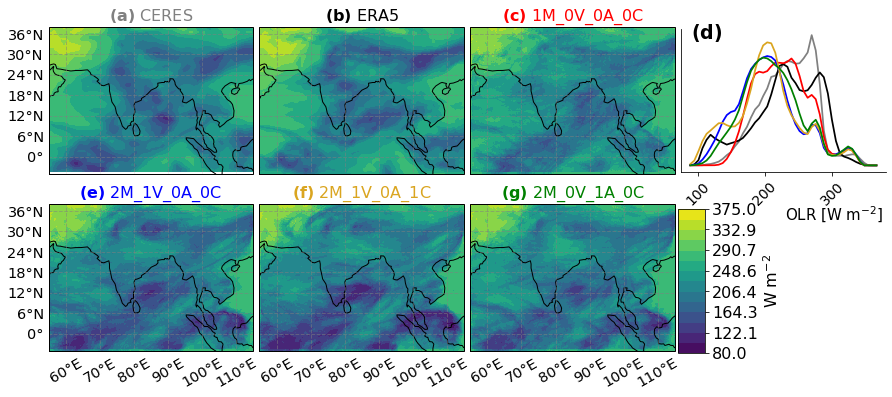

In [244]:
fs = 16
fig = plt.figure(figsize=(15,6.5))
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
gs = fig.add_gridspec(4,4)

c = 0
for j in np.arange(2):
    for i in np.arange(3):
        #print(i,j,c)
        ax = fig.add_subplot(gs[j*2:j*2+2,i], projection=ccrs.PlateCarree())
        ax.set_title(titre[c],color=farbe[c],fontsize=fs)
        im = ax.contourf(lons[c],lats[c],olr[c],levels=levs,cmap=cm.viridis,\
                  transform=ccrs.PlateCarree())
        gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
                linewidth=1,color='gray',alpha=0.5,linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        if i != 0:
            gl.ylabels_left = False
        if j == 0:
            gl.xlabels_bottom = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.rotate_labels=True
        gl.xlabel_style = {'size': fs-1.5,'rotation': 30}
        gl.ylabel_style = {'size': fs-1.5}

        ax.set_extent([55,115,-5,38],crs=ccrs.PlateCarree())
        im.set_clim([80,375])
        ax.coastlines()
        c += 1

fig.canvas.mpl_connect('resize_event', resize_colorbar)
cb = plt.colorbar(im,label=r'W m$^{-2}$',cax=cbar_ax)
cb.set_label(label=r'W m$^{-2}$',fontsize=fs)
resize_colorbar(None)

ax = fig.add_subplot(gs[:2,3])
levs = np.linspace(80,375,50)
h = np.zeros((6,len(levs)-1))
for i, o in enumerate(olr):
    h[i], b = np.histogram(o,bins=levs,density=True)
    ax.plot(moving_average((levs[1:] + levs[:-1])/2,3), moving_average(h[i],3),
            linewidth=1.75, color=farbe[i])

sexy_axes(ax,fs-2)
ax.get_yaxis().set_visible(False)
ax.set_xlabel(r'OLR [W m$^{-2}$]',fontsize=fs-1)
ax.xaxis.set_label_coords(0.75, -0.23)
ax.text(0.05,0.93,r'$\bf{' + '(d)' + '}$',fontsize=fs+3,weight='bold',transform=ax.transAxes)

# This little diddy adjusts the aspect ratio in display coordinates.
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*0.7)
gs.update(wspace=0.03, hspace=0.01) 
#fig.savefig('./output/1-olr-comparison.png',bbox_inches='tight')

## Figure 3: Heating profiles

In [12]:
# Load the simulation heating rate profiles.
suffix2 = '_PL2'
factor = 7 # to permit comparison to CloudSat
sims = ['1mom', 'no2mom', 'novgrid', '2mom', 'radnovgrid', 'rad2mom', 'PDA'] #, 'Atest'
acronym = ['1M_0V_0A_0C', '', '2M_0V_0A_0C', '', '2M_0V_0A_1C', '', '2M_0V_1A_0C']
H = np.zeros((len(sims)+3, 2, 120-factor))

In [13]:
# In order to compare to the CloudSat profiles, we take the <factor> element to the end only.
# We need all sim pl values to fall within the range of CS pl values in order to interpolate.
for j, s in enumerate(sims):
    # Take the average over the first dimension - 24 hours.
    vals = np.load('./output/H_' + s + suffix2 + '.npy')
    vals = vals[:,0,factor:] + vals[:,1,factor:]
    H[j] = np.nanmedian(vals, axis=0)

# Load the pressure levels
pl = np.loadtxt('./remapping/PMEAN_48-72.txt')[factor:]
farbe = ['red', 'red', 'blue', 'blue', 'goldenrod', 'goldenrod','green','purple']
stil = ['--', '-', '--', '-', '--', '-' , '-', ':']

In [14]:
# Load the ERA5 heating profiles. Subtract all-sky and clear-sky values.
# In order to compare to the CloudSat profiles, we take the fifth element to the end only.
# Multiply by 86400 to convert K s-1 to K day-1.
basedir2 = '/work/bb1018/b380873/tropic_vis/obs/ERA5/'
vals_ERA5 = xr.open_dataset(basedir2 + 'ERA5_ddtmean_20170807-20170808_55e115e5s40n_PL.nc')
vals1 = vals_ERA5.mttlwr.mean(dim={'lat','lon'}) - vals_ERA5.mttlwrcs.mean(dim={'lat','lon'})
vals1 = vals1.values[6:30,factor:]*86400
vals2 = vals_ERA5.mttswr.mean(dim={'lat','lon'}) - vals_ERA5.mttswrcs.mean(dim={'lat','lon'})
vals2 = vals2.values[6:30,factor:]*86400
vals = vals1 + vals2
H[j+1] = np.nanmedian(vals1 + vals2,axis=0)

In [90]:
# Load the ERAI heating profiles.
basedir2 = '/work/bb1018/b380873/tropic_vis/obs/ERAI/'
vals_ERAI = xr.open_dataset(basedir2 + 'ERAI_ddt_mean_20170807-20170808_55e115e5s40n_PL_named.nc')
vals1 = vals_ERAI.mttlwr.mean(dim={'time','lat','lon'}) - vals_ERAI.mttlwrcs.mean(dim={'time','lat','lon'})
vals1 = vals1.values[factor:]
vals2 = vals_ERA5.mttswr.mean(dim={'time','lat','lon'}) - vals_ERAI.mttswrcs.mean(dim={'time','lat','lon'})
vals2 = vals2.values[factor:]
vals = vals1 + vals2
H[j+2] = vals2 #np.nanmedian(vals2,axis=0)

In [15]:
# Level conversions from ERA: https://www.ecmwf.int/en/forecasts/documentation-and-support/60-model-levels
alt = np.asarray([26994.77,25585.48,24185.62,22795.11,21413.91,20077.62,18810.77,\
        17612.18,16482.75,15418.43,14415.44,13470.22,12579.42,11739.87,10948.81,10191.54,\
       9458.63,8749.51,8064.40,7403.97,6769.08,6160.62,5579.46,5026.39,4502.09,\
       4007.11,3541.93,3106.86,2702.14,2327.89,1984.11,1670.7,1387.43,1133.93,\
       909.7,714.05,546.11,404.74,288.57,195.85,124.48])
press = np.asarray([20.8227,25.7989,31.9642,39.6029,49.0671,60.1802,73.0663,87.7274,\
         104.2288,122.6137,142.9017,165.0886,189.1466,215.0251,242.6523,272.0593,\
         303.2174,336.0439,370.4072,406.1328,443.0086,480.7907,519.2093,557.9734,\
         596.7774,635.3060,673.2403,710.2627,746.0635,780.3455,812.8303,843.2634,\
         871.4203,897.1118,920.1893,940.5511,958.1477,972.9868,985.1399,994.7472,\
         1002.0236])

# The factor of 100 below is to map to pressure levels [=] Pa.
cubic_interp = interp1d(alt, press*100, kind='cubic')

In [16]:
# Level conversions assuming hydrostasy with p0 = 1013.25 hPa and H = 7.5 km
press = 1013.25*np.exp(-alt/7500)
cubic_interp = interp1d(alt, press*100, kind='cubic')

In [17]:
# Load the CloudSat heating profile
basedir = '/pf/b/b380796/work/cloudsatcalipso/acre_3d/clim/'
file = 'cloudsat_calipso_asianmonsoon_3d_acre_multiyear_august_clim.nc'
vals_CS = xr.open_dataset(basedir + file)

# Convert the altitudes to pressure levels using the interpolation function above.
levs_CS = vals_CS.lev.values
pl_CS = cubic_interp(levs_CS)
print('First two values within the range of the second two?')
print(pl.min(),pl.max(),pl_CS.min(),pl_CS.max())

# Interpolate from the CloudSat pressure levels to the simulation ones.
vals1 = vals_CS.lw_acre_clim.mean(dim={'lat','lon'}).values[0]
vals2 = vals_CS.sw_acre_clim.mean(dim={'lat','lon'}).values[0]
cubic_interp2 = interp1d(pl_CS, vals1, kind='cubic')
H[j+3,0] = cubic_interp2(pl)
cubic_interp2 = interp1d(pl_CS, vals2, kind='cubic')
H[j+3,1] = cubic_interp2(pl)

First two values within the range of the second two?
4157.149068196614 93646.37109375 3642.6852170097704 95056.02983901025


In [18]:
# Read in Aiko's MPI and LMD simulations
bd = './output/'
mpi_dtlw_trop = np.load(bd + 'mpi_dtlw_trop',allow_pickle=True)
mpi_dtlwcs_trop = np.load (bd + 'mpi_dtlwcs_trop',allow_pickle=True)
mpi_dtsw_trop = np.load(bd + 'mpi_dtsw_trop',allow_pickle=True)
mpi_dtswcs_trop = np.load(bd + 'mpi_dtswcs_trop',allow_pickle=True)
mpi_dtlev = np.load(bd + 'mpi_dtlev',allow_pickle=True)

mpi_dtlw_AMA = np.load(bd + 'mpi_dtlw_AMA',allow_pickle=True)
mpi_dtlwcs_AMA = np.load(bd + 'mpi_dtlwcs_AMA',allow_pickle=True)
mpi_dtsw_AMA = np.load(bd + 'mpi_dtsw_AMA',allow_pickle=True)
mpi_dtswcs_AMA = np.load(bd + 'mpi_dtswcs_AMA',allow_pickle=True)
mpi_dtlev_AMA = np.load(bd + 'mpi_AMA',allow_pickle=True)

lmd_dtlw_trop = np.load(bd + 'lmd_dtlw_trop',allow_pickle=True)
lmd_dtlwcs_trop = np.load(bd + 'lmd_dtlwcs_trop',allow_pickle=True)
lmd_dtsw_trop = np.load(bd + 'lmd_dtsw_trop',allow_pickle=True)
lmd_dtswcs_trop = np.load(bd + 'lmd_dtswcs_trop',allow_pickle=True)
lmd_dtlev = np.load(bd + 'lmd_dtlev.npy')

lmd_dtlw_AMA = np.load(bd + 'lmd_dtlw_AMA',allow_pickle=True)
lmd_dtlwcs_AMA = np.load(bd + 'lmd_dtlwcs_AMA',allow_pickle=True)
lmd_dtsw_AMA = np.load(bd + 'lmd_dtsw_AMA',allow_pickle=True)
lmd_dtswcs_AMA = np.load(bd + 'lmd_dtswcs_AMA',allow_pickle=True)
lmd_dtlev_AMA = np.load(bd + 'lmd_dtlev_AMA.npy')

[ 0.01395801  0.02755974  0.04705276  0.03199048  0.01740629  0.01592906
  0.01196361 -0.03163343 -0.08108498 -0.0716679  -0.05598863 -0.04868155
 -0.04571244 -0.03709572 -0.00307479  0.06094942  0.08591266  0.15225585
  0.22557334  0.2433084   0.25601164  0.27204607  0.26048937  0.16524981
  0.09406229  0.10732199  0.11521367  0.08621946  0.02466508 -0.0747741
 -0.12109875 -0.13159859 -0.08257566  0.04969892  0.16075809  0.27155471
  0.31780716]
[5.00e+01 1.00e+02 2.00e+02 3.00e+02 5.00e+02 7.00e+02 1.00e+03 1.50e+03
 2.10e+03 2.80e+03 3.50e+03 4.50e+03 6.00e+03 7.50e+03 9.00e+03 1.10e+04
 1.30e+04 1.55e+04 1.80e+04 2.10e+04 2.50e+04 3.00e+04 3.70e+04 4.50e+04
 5.30e+04 6.10e+04 6.80e+04 7.50e+04 8.20e+04 8.70e+04 9.00e+04 9.20e+04
 9.50e+04 9.70e+04 9.80e+04 9.90e+04 1.00e+05]


(80000, 5000)

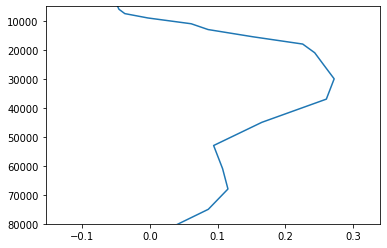

In [70]:
# Read in Nicole's ICON simulations
#bd = '/scratch/b/b380873/'
#infile = 'ICON-NWP_prp_AMIP_free_3d_fluxes_heatingrates_mm.nc'
#xfi = xr.open_dataset(bd + infile)
##  Factor of 86400 converts K day-1 to K s-1
#icon_dtsw = xfi.ddt_temp_radsw.mean({'time','lat','lon'}).values*86400
#icon_dtlw = xfi.ddt_temp_radlw.mean({'time','lat','lon'}).values*86400
#icon_dt = -1.*( icon_dtsw + icon_dtlw )
#icon_dtlev = xfi.lev.values

H_ICON_AMIP = np.load('./output/H_ICON-AMIP_tropic_mm.npy')
H_ICON_AMIP = np.nanmean(H_ICON_AMIP,axis=0)
lev_ICON_AMIP = np.load('./output/lev_ICON-AMIP_mm.npy')

# Interpolate these ICON values to 
#print(icon_dtlev)
#print(icon_dtsw)
#print(icon_dtlw)
print(H_ICON_AMIP[:,0]+H_ICON_AMIP[:,1])
print(lev_ICON_AMIP)
plt.plot(H_ICON_AMIP[:,0]+H_ICON_AMIP[:,1],lev_ICON_AMIP)
plt.gca().invert_yaxis()
plt.gca().set_yscale()
plt.ylim([80000,5000])

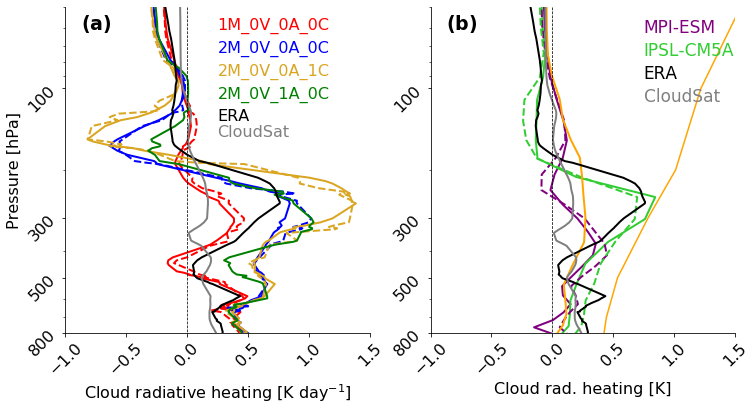

In [64]:
fs = 16
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
for j, a, rad in zip(np.arange(len(sims)), acronym, H):
    ax[0].plot((rad[0] + rad[1])/2, pl/100, ls = stil[j], lw = 2, color=farbe[j])
    ax[0].text(0.5,0.93-0.035*j, a, fontsize=fs, color=farbe[j], transform=ax[0].transAxes)

ax[0].plot((H[j+1,0] + H[j+1,1])/2, pl/100, lw = 2, color='k')
#ax[0].plot((H[j+2,0] + H[j+2,1])/2, pl/100, lw = 2, color='k', linestyle='--')
ax[0].text(0.5,0.93-0.04*(j+1), 'ERA', fontsize=fs, color='k', transform=ax[0].transAxes)

ax[0].plot((H[j+3,0] + H[j+3,1])/2, pl/100, lw = 2, color='gray')
ax[0].text(0.5,0.93-0.041*(j+2), 'CloudSat', fontsize=fs, color='gray', transform=ax[0].transAxes)
ax[0].plot([0,0],[50,1000], lw=0.75, linestyle='--', color='k')
ax[0].text(0.05,0.93,r'$\bf{' + '(a)' + '}$',fontsize=fs+3,weight='bold',transform=ax[0].transAxes)
ax[0].set_xlabel(r'Cloud radiative heating [K day$^{-1}$]',fontsize=fs)
ax[0].set_xlim([-1,1.5])
sexy_axes2(ax[0],fs,True)

ax[1].plot((mpi_dtlw_trop-mpi_dtlwcs_trop)+(mpi_dtsw_trop-mpi_dtswcs_trop),mpi_dtlev/100,
         color='purple',linewidth=2)
ax[1].plot(((lmd_dtlw_trop-lmd_dtlwcs_trop)+(lmd_dtsw_trop-lmd_dtswcs_trop)),lmd_dtlev/100,
         color='limegreen',linewidth=2)
ax[1].plot((mpi_dtlw_AMA-mpi_dtlwcs_AMA)+(mpi_dtsw_AMA-mpi_dtswcs_AMA),mpi_dtlev_AMA/100,'--',
         color='purple',linewidth=2)
ax[1].plot(((lmd_dtlw_AMA-lmd_dtlwcs_AMA)+(lmd_dtsw_AMA-lmd_dtswcs_AMA)),lmd_dtlev_AMA/100,'--',
         color='limegreen',linewidth=2)
ax[1].plot(H_ICON_AMIP[:,0] + H_ICON_AMIP[:,1],lev_ICON_AMIP/100,
         color='orange',linewidth=2)

ax[1].plot((H[j+1,0] + H[j+1,1])/2, pl/100, lw = 2, color='k')
#ax[1].plot((H[j+2,0] + H[j+2,1])/2, pl/100, lw = 2, color='k', linestyle='--')
ax[1].plot((H[j+3,0] + H[j+3,1])/2, pl/100, lw = 2, color='gray')
ax[1].plot(icon_dt,icon_dtlev,color='orange')
ax[1].text(0.7,0.92,'MPI-ESM',fontsize=fs+1,color='purple',transform=plt.gca().transAxes)
ax[1].text(0.7,0.85,'IPSL-CM5A',fontsize=fs+1,color='limegreen',transform=plt.gca().transAxes)
ax[1].text(0.7,0.78,'ERA',fontsize=fs+1,color='k',transform=plt.gca().transAxes)
ax[1].text(0.7,0.71,'CloudSat',fontsize=fs+1,color='gray',transform=plt.gca().transAxes)
ax[1].plot([0,0],[50,1000], lw=0.75, linestyle='--', color='k')
ax[1].text(0.05,0.93,r'$\bf{' + '(b)' + '}$',fontsize=fs+3,weight='bold',transform=ax[1].transAxes)
ax[1].set_xlabel('Cloud rad. heating [K]',fontsize=fs)
ax[1].set_xlim([-1,1.5])
sexy_axes2(ax[1],fs,False)

#fig.savefig('./output/1-heating-profiles.pdf',bbox_inches='tight')

## Figure 4: Process figure - qi and qs profiles, ice effective radius and emissivity

In [122]:
# Load the ice and snow mass mixing ratio profiles.
QI = np.zeros((len(sims), 120))  # second dimension = level number
QS = np.zeros((len(sims), 120))
for j, s in enumerate(sims):
    # Take the average over the first dimension - 24 hours.
    QI[j] = np.nanmean(np.load('./output/QI_' + s + suffix2 + '.npy'), axis=0)
    QS[j] = np.nanmean(np.load('./output/QS_' + s + suffix2 + '.npy'), axis=0)

In [129]:
# Effective radius difference between the old and new parameterizations
a0 = 83.8
b0 = 0.216
N = np.linspace(0.1,210,50) # in [cm-3]
iwc = [0.01, 0.1, 0.5, 1]   # in [g m-3]
re_old = np.zeros((len(iwc),len(N)))

nu = 0
mu = 0.333333
ageo = 0.835
bgeo = 0.39
part1 = ageo/2*(gamma((nu + 1)/mu)/gamma((nu + 2)/mu))**bgeo
part2 = gamma((3*bgeo + nu + 1)/mu)/gamma((2*bgeo + nu + 1)/mu)
re_new = np.zeros((len(iwc),len(N)))

for indx, i in enumerate(iwc):
    re_old[indx] = (a0*i**b0)*np.ones(len(N))
    re_new[indx] = part1*part2*((i/10**3)/(N*10**6))**bgeo*10**6

In [154]:
# Emissivity difference as reff changes
cldopt = xr.open_dataset('/work/bb1018/b380873/rrtm/rrtm_cldopt.nc')
wavel = cldopt.wavelength
ri = cldopt.re_crystal
# 30 wavelengths, 61 effective radii
kappa = cldopt.extinction_per_mass_crystal

# Generate an interpolation function kappa = f(reff)
cubic_interp = interp1d(ri, kappa, kind='cubic')

In [173]:
# Look at the effective radii associated with IWC = 0.01 g m-3

# Where r_new or r_old are less than the tabulated minimum set them to min.
r_new = re_new[0]; r_old = re_old[0]
r_new[np.argwhere((r_new < np.nanmin(ri)))[:,0]] = np.nanmin(ri)
r_old[np.argwhere((r_old < np.nanmin(ri)))[:,0]] = np.nanmin(ri)
    
# Where r_new or r_old are greater than the tabulated maximum set them to max.
r_new[np.argwhere((r_new > np.nanmax(ri)))[:,0]] = np.nanmax(ri)
r_old[np.argwhere((r_old > np.nanmax(ri)))[:,0]] = np.nanmax(ri)
        
# Interpolate the r_new and r_old values onto the fixed RRTM kappa = f(reff) function.
kappa_new_cubic = cubic_interp(r_new)
kappa_old_cubic = cubic_interp(r_old)

(4, 50)
(50,)
(30, 50)


[ 4  7 10 13 16 19]


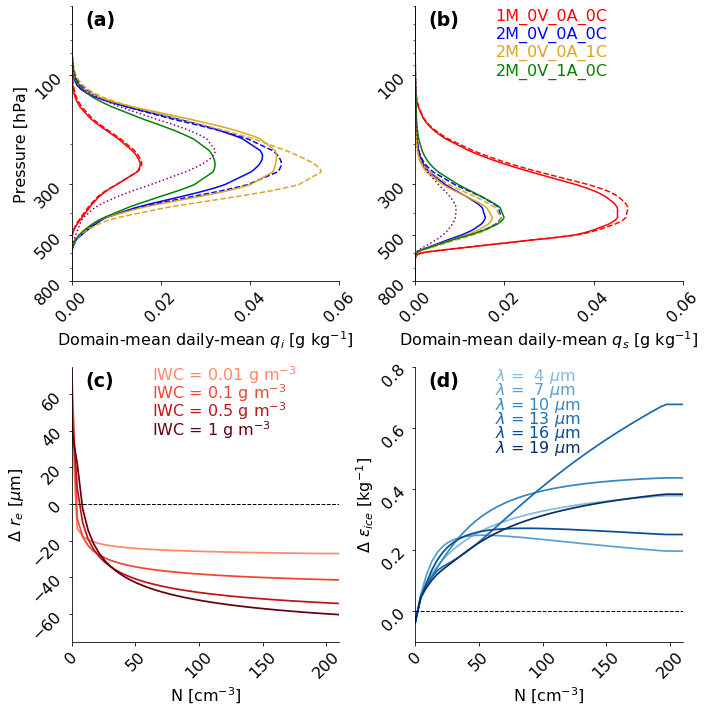

In [187]:
fs = 16
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
for j, ice, snow, a in zip(np.arange(len(sims)), QI, QS, acronym):
    ax[0,0].plot(ice*1000, pl/100, ls = stil[j], color=farbe[j])
    ax[0,1].plot(snow*1000, pl/100, ls = stil[j], color=farbe[j])
    ax[0,1].text(0.3, 0.95-j*0.033, a, color=farbe[j], fontsize=fs, transform=ax[0,1].transAxes)
    
ax[0,0].set_xlim([0,0.06])
ax[0,0].set_xlabel(r'Domain-mean daily-mean $q_i$ [g kg$^{-1}$]',fontsize=fs)
ax[0,0].text(0.05,0.93,'(a)',fontsize=fs+3,weight='bold',transform=ax[0,0].transAxes)
sexy_axes2(ax[0,0], fs, True)

ax[0,1].set_xlim([0,0.06])
ax[0,1].set_xlabel(r'Domain-mean daily-mean $q_s$ [g kg$^{-1}$]',fontsize=fs)
ax[0,1].text(0.05,0.93,'(b)',fontsize=fs+3,weight='bold',transform=ax[0,1].transAxes)
sexy_axes2(ax[0,1], fs, False)

cmapz = cm.Reds(np.linspace(0,1,6))
for i in np.arange(4):
    ax[1,0].plot(N,re_new[i] - re_old[i], linewidth=1.75, color=cmapz[i+2])
    ax[1,0].text(0.3,0.95-i*0.066, 'IWC = '+str(iwc[i]) + ' g m$^{-3}$', color=cmapz[i+2],
                transform=ax[1,0].transAxes, fontsize=fs)
ax[1,0].plot([0,210],[0,0],linewidth=1,linestyle='--',color='k')
ax[1,0].set_xlim([0,210])
ax[1,0].set_ylim([-75,75])
ax[1,0].set_xlabel(r'N [cm$^{-3}$]',fontsize=fs)
ax[1,0].set_ylabel('$\Delta$ $r_e$ [$\mu$m]',fontsize=fs)
ax[1,0].text(0.05,0.93,'(c)',fontsize=fs+3,weight='bold',transform=ax[1,0].transAxes)
sexy_axes(ax[1,0],fs)

wavel_sub = np.arange(4,20,3)
cmapz = cm.Blues(np.linspace(0,1,len(wavel_sub)+4))
for i, wl in enumerate(wavel_sub):
    ax[1,1].plot(N, kappa_new_cubic[wl] - kappa_old_cubic[wl], linewidth=1.75, color=cmapz[i+4])
    ax[1,1].text(0.3,0.95-i*0.052, r'$\lambda$ =' + '{0:3.0f}'.format(wl)+r' $\mu$m', color=cmapz[i+4],
                transform=ax[1,1].transAxes, fontsize=fs)
    
ax[1,1].plot([0,210],[0,0],linewidth=1,linestyle='--',color='k')
ax[1,1].set_xlim([0,210])
ax[1,1].set_ylim([-0.1,0.8])
ax[1,1].set_xlabel(r'N [cm$^{-3}$]',fontsize=fs)
ax[1,1].set_ylabel('$\Delta$ $\epsilon_{ice}$ [kg$^{-1}$]',fontsize=fs)
ax[1,1].text(0.05,0.93,'(d)',fontsize=fs+3,weight='bold',transform=ax[1,1].transAxes)
sexy_axes(ax[1,1],fs)

fig.tight_layout()
#fig.savefig('./output/1-qi-qs-reff-emiss.pdf',bbox_inches='tight')